# Script to analyse models for province 2

In [1]:
import joblib
import xarray as xr
import pandas as pd

## Load model

In [2]:
filename = "/home/jovyan/lustre_scratch/models/random_forest_2_otherhalf.joblib"

In [3]:
rf_2 = joblib.load(open(filename, "rb"))

/home/jovyan/lustre_scratch/conda-envs/rapids_env/lib/python3.9/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.0 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
filename = "/home/jovyan/lustre_scratch/models/random_forest_2.joblib"

In [5]:
rf_1 = joblib.load(open(filename, "rb"))

## Load .nc in xarray for province

In [6]:
filename = '/home/jovyan/lustre_scratch/province_dataframes/full_province2'+'.nc'

In [7]:
d = xr.load_dataset(filename)

In [8]:
d_1 = d.sel(longitude=slice(-25,10))
d_2 = d.sel(longitude=slice(10,50))

## Split to test data

In [9]:
#slices
slice_1 = slice('1998-01-01','2000-12-01')
slice_2 = slice('2001-01-01','2004-12-01')
slice_3 = slice('2005-01-01','2008-12-01')
slice_4 = slice('2009-01-01','2012-12-01')
slice_5 = slice('2013-01-01','2016-12-01')

In [10]:
#fold 3 
test_1 = d_1.sel(time=slice_3)
test_2 = d_2.sel(time=slice_3)

In [11]:
stacked = d_1.stack(coord=['longitude', 'latitude']).to_dataframe()
stacked.drop(columns=['spatial_ref','longitude', 'latitude'],inplace=True)
stacked.dropna(inplace=True)
stacked.reset_index(drop=True,inplace=True)
std_1 = stacked.rrs.std()

In [12]:
stacked = d_2.stack(coord=['longitude', 'latitude']).to_dataframe()
stacked.drop(columns=['spatial_ref','longitude', 'latitude'],inplace=True)
stacked.dropna(inplace=True)
stacked.reset_index(drop=True,inplace=True)
std_2 = stacked.rrs.std()

## Prep data

In [13]:
stacked_test = test_1.stack(coord=['longitude', 'latitude']).to_dataframe()
stacked_test.drop(columns=['spatial_ref','longitude', 'latitude'],inplace=True)
stacked_test.dropna(inplace=True)
stacked_test.reset_index(drop=True,inplace=True)

stacked_test['rrs'].where(stacked_test['rrs']<std_1, other=1, inplace=True)
rrs_ones = (stacked_test['rrs'] == 1).sum()
rrs_zeros = (stacked_test['rrs'] == 0).sum()

non_zero = stacked_test.loc[stacked_test['rrs'] == 1.]
non_zero = non_zero[stacked_test.columns]

zero = stacked_test.loc[stacked_test['rrs'] == 0.]
zero = zero[stacked_test.columns]
zero_samp = zero.sample(rrs_ones)

full_test_1 = pd.concat([zero_samp,non_zero])
X_test_1 = full_test_1.drop(columns='rrs')
y_test_1 = full_test_1['rrs']

In [14]:
test_accuracy = rf_1.score(X_test_1, y_test_1)

In [15]:
print('test_accuracy model 1:' ,test_accuracy)

test_accuracy model 1: 0.8835633626097867


In [16]:
stacked_test = test_2.stack(coord=['longitude', 'latitude']).to_dataframe()
stacked_test.drop(columns=['spatial_ref','longitude', 'latitude'],inplace=True)
stacked_test.dropna(inplace=True)
stacked_test.reset_index(drop=True,inplace=True)

stacked_test['rrs'].where(stacked_test['rrs']<std_2, other=1, inplace=True)
rrs_ones = (stacked_test['rrs'] == 1).sum()
rrs_zeros = (stacked_test['rrs'] == 0).sum()

non_zero = stacked_test.loc[stacked_test['rrs'] == 1.]
non_zero = non_zero[stacked_test.columns]

zero = stacked_test.loc[stacked_test['rrs'] == 0.]
zero = zero[stacked_test.columns]
zero_samp = zero.sample(rrs_ones)

full_test_2 = pd.concat([zero_samp,non_zero])
X_test_2 = full_test_2.drop(columns='rrs')
y_test_2 = full_test_2['rrs']

In [17]:
print('test_accuracy model 1:' ,test_accuracy)

test_accuracy model 1: 0.8835633626097867


## SHAP

In [18]:
import shap

In [19]:
sh_1 = shap.TreeExplainer(rf_1,X_test_1,model_output='probability',feature_perturbation='interventional')

In [20]:
sample_1 = X_test_1.sample(2000)

In [21]:
sample_1

,SST,Wind speed mean,Wind speed std,Wind stress mean,Wind stress std,SLA,MLD,PAR
430048,287.826050,5.392578,2.402344,0.045250,0.044899,0.0102,11.500000,1699936.375
600730,280.343689,10.643555,2.930664,0.233658,0.163277,0.0365,42.000000,1048756.750
147672,284.417969,6.540039,3.042969,0.082993,0.097237,0.0325,12.699951,1573357.250
374057,277.643890,8.091797,4.420898,0.162804,0.233971,0.0037,28.500000,2136301.500
373934,277.499512,8.272461,4.567383,0.173584,0.264755,0.0059,25.000000,2109283.000
...,...,...,...,...,...,...,...,...
869224,277.174316,9.151367,3.015625,0.185425,0.138535,-0.0330,228.399902,1029140.625
695307,286.129852,6.874023,3.008789,0.088799,0.091537,-0.0011,17.399902,1710965.750
98106,274.860931,7.953125,3.637695,0.135254,0.137253,0.0053,56.800049,2112170.000
721939,286.020142,7.441406,3.328125,0.109894,0.110756,0.0320,20.899902,841492.625


In [22]:
sh_val_1 = sh_1.shap_values(sample_1)

100%|===================| 3999/4000 [04:11<00:00]        

In [23]:
import numpy as np

In [24]:
global_values = [np.mean(i) for i in np.rollaxis(abs(sh_val_1[1]), 1)]

In [25]:
global_values

[0.034396502102421025,
 0.0875889994747437,
 0.02750504756554807,
 0.0644774820209129,
 0.01635548374277114,
 0.010194065633790684,
 0.052769389110689964,
 0.08486080287448167]

In [26]:
import matplotlib.pyplot as plt

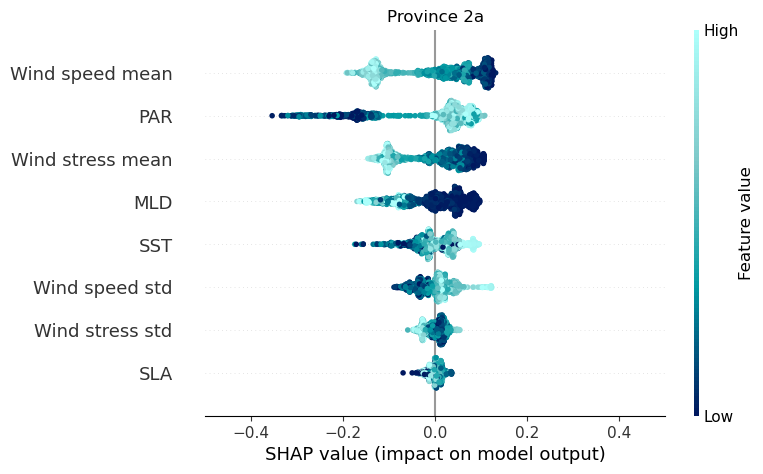

In [41]:

shap.summary_plot(sh_val_1[1],sample_1,plot_type='dot',cmap=cmap,show=False) #show=False)
ax = plt.gca()
ax.set_xlim(-0.5, 0.5) 
plt.title('Province 2a')
plt.savefig('/home/jovyan/lustre_scratch/Figures/model_shap_analysis_redo/province_2a.png')
plt.show()

In [30]:
sh_2 = shap.TreeExplainer(rf_2,X_test_2,model_output='probability',feature_perturbation='interventional')

In [31]:
sample_2 = X_test_2.sample(2000)

In [32]:
sample_2

,SST,Wind speed mean,Wind speed std,Wind stress mean,Wind stress std,SLA,MLD,PAR
444744,280.861359,6.508789,2.609375,0.074677,0.067558,-0.0425,14.599854,1210718.875
317176,280.076630,8.572266,3.202148,0.154907,0.126945,0.0742,17.300049,60402.750
441926,279.851440,6.108398,3.023438,0.078751,0.095375,-0.0001,15.599854,891384.000
444556,280.866882,6.535156,2.642578,0.075676,0.068466,-0.0446,14.399902,1221452.250
294033,282.310120,4.850586,2.207031,0.038231,0.041245,0.0266,17.899902,530818.375
...,...,...,...,...,...,...,...,...
446042,280.230865,6.101562,2.629883,0.067757,0.073540,0.0223,15.500000,1026846.000
319430,279.172638,8.603516,3.256836,0.154182,0.129745,0.0685,16.399902,72320.500
605668,276.007355,6.081055,2.666016,0.062874,0.063545,-0.0526,15.000000,1747903.250
169796,278.253845,9.067383,2.857422,0.153275,0.117088,0.1365,15.000000,5996.000


In [33]:
sh_val_2 = sh_2.shap_values(sample_2)

 98%|===================| 3932/4000 [00:39<00:00]        

In [37]:
global_values = [np.mean(i) for i in np.rollaxis(abs(sh_val_2[1]), 1)]

In [38]:
global_values

[0.10723063371229122,
 0.027551195591920687,
 0.02741630997852489,
 0.043108599174587287,
 0.03774605524279417,
 0.011041408222526552,
 0.055384268603992516,
 0.08532739717803674]

In [39]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(0, 24/255, 95/255),(0, 154/255, 162/255),(126/255, 201/255, 201/255),(173/255, 255/255, 251/255)]#,'#C5FFFC']
cmap = LinearSegmentedColormap.from_list('coccolithphores', colors, N=100)

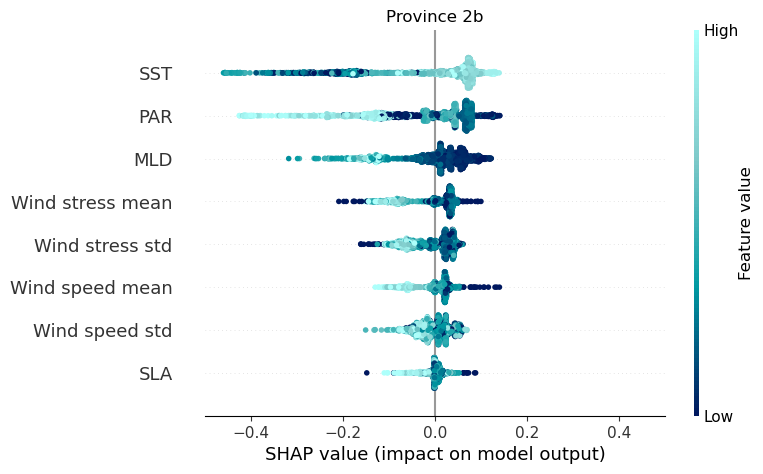

In [42]:
shap.summary_plot(sh_val_2[1],sample_2,plot_type='dot',cmap=cmap,show=False) #show=False)
ax = plt.gca()
ax.set_xlim(-0.5, 0.5) 
plt.title('Province 2b')
plt.savefig('/home/jovyan/lustre_scratch/Figures/model_shap_analysis_redo/province_2b.png')
plt.show()

In [83]:
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
pio.renderers.default = 'iframe'

In [95]:
colors = px.colors.qualitative.T10
print(colors)

['#4C78A8', '#F58518', '#E45756', '#72B7B2', '#54A24B', '#EECA3B', '#B279A2', '#FF9DA6', '#9D755D', '#BAB0AC']


In [130]:
colors = ['#E45756','#72B7B2','#54A24B','#FF9DA6','#B279A2','#F58518', '#4C78A8','#EECA3B']

In [112]:
import seaborn as sns

In [131]:
sns.set_theme()
fig = go.Figure(data=go.Barpolar(r=rf_2.feature_importances_,theta=rf_2.feature_names_in_,marker_color=colors))#,mode = 'markers'))
fig.update_layout(showlegend=False)
#fig.update_traces(fill='toself')
fig.update_traces(legendgrouptitle_font_size=40) 
fig.update_polars(angularaxis_tickfont_size=20)
fig.update_polars(radialaxis_nticks=1)
#fig.update_traces(marker_color=colors)
fig.show()

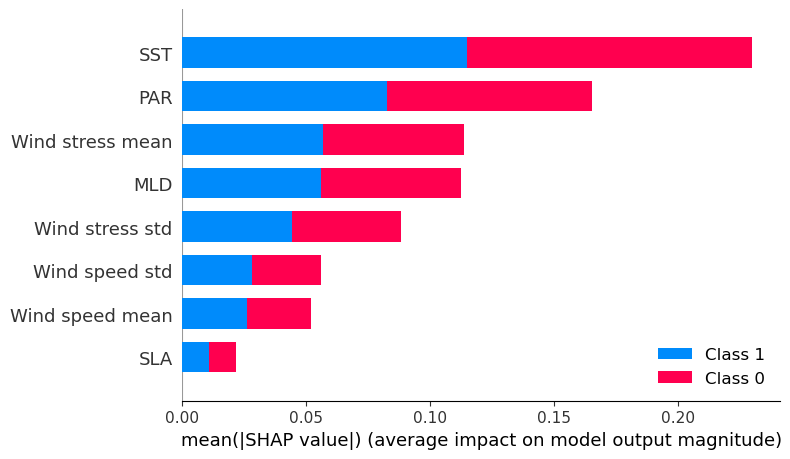

In [46]:
shap.summary_plot(sh_val_2, sample_2)

In [47]:
import matplotlib.pyplot as plt
import numpy as np

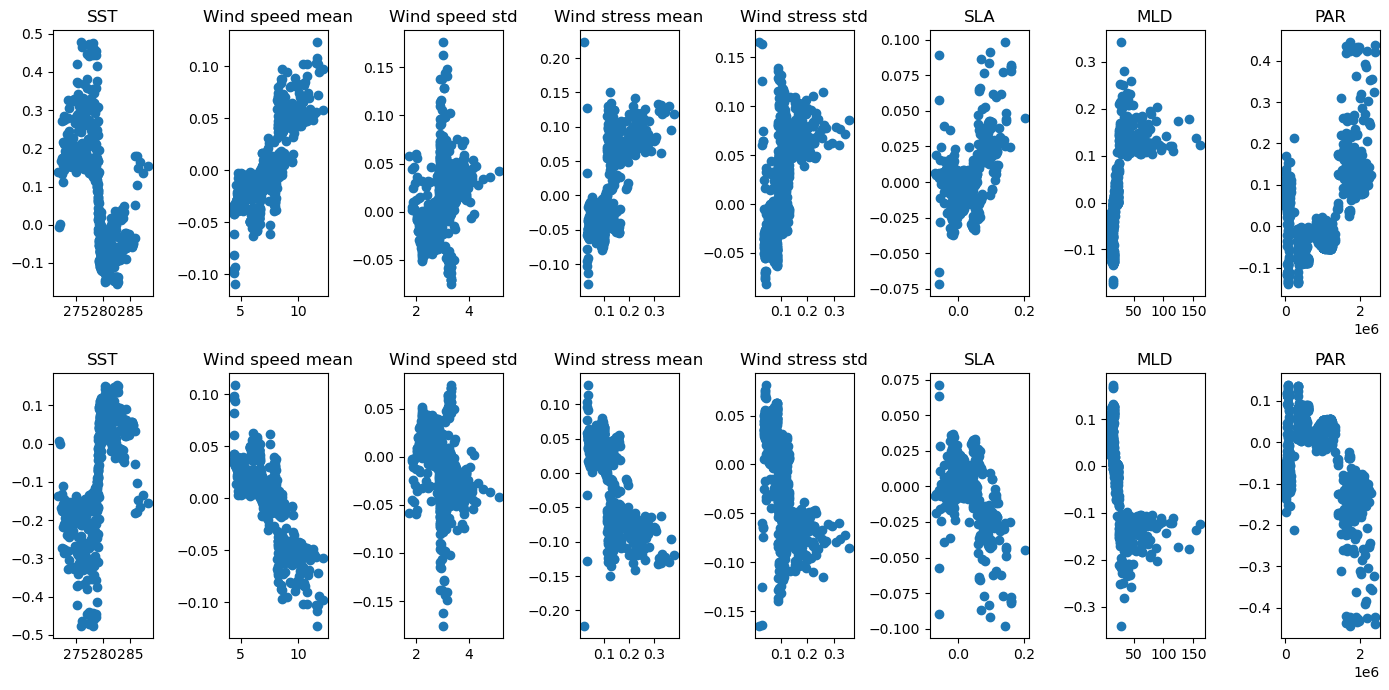

In [48]:
#shap.initjs()
fig, ax = plt.subplots(2,int(len(X_test_2.columns)), figsize=(14, 7))
#ax = ax.flatten()
for j in range(0,2):
    sv = sh_val_2[j]
    for i, f in enumerate(X_test_2.columns):
        #print(i)
        axes = ax[j,i]
        #print(type(sv.T[i]), type(sample_1[f].values))
        axes.scatter(sample_2[f].values,sv.T[i])
        #, feature_names=X_test_1.columns, show=False,ax=axes,interaction_index=None)
        axes.set_title(f)
plt.tight_layout()
plt.show()